In [1]:
import os
import sys
sys.path.append('..')
os.chdir('..')

import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

from data_loader.dataset import getDataloaders
from utils.util import initModel
from model.loss import getTotalLoss
from model.metrics  import getSegAccuracy, getClsAccuracy, getAuxAccuracy
from configs.config_parser import Config

In [2]:
conf = Config().getConfig()
trainLoader, testLoader = getDataloaders(conf)
model = initModel(conf).to(conf.GPU_ID)
lossFunc = getTotalLoss
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=conf.INIT_LR, weight_decay=1e-5)

H = {}
H["train_loss"] = []
H["test_loss"] = []
H["cls_test_acc"] = []
H["cls_train_acc"] = []
H["seg_test_acc"] = []
H["seg_train_acc"] = []
H["aux_test_acc"] = []
H["aux_train_acc"] = []

[INFO] MODE: encoder, DATASET: all, FREEZING: ['out1'], LOSS: segmentation
[INFO] loading training/testing split...
[INFO] found 1425 examples in the training set...
[INFO] found 249 examples in the test set...
------------------------------------------------------------


In [3]:
img, msk, lbl = next(iter(trainLoader))

In [28]:
# plt.imshow(img[0].squeeze(), cmap = 'gray')

In [3]:
# loop over epochs
print("[INFO] training the network...")
for epoch in tqdm(range(conf.NUM_EPOCHS)):
    model.train()
    totalTestLoss, totalTrainLoss = 0, 0
    totalTestSegAcc, totalTrainSegAcc = 0, 0
    totalTestClsAcc, totalTrainClsAcc = 0, 0 
    totalTestAuxAcc, totalTrainAuxAcc = 0, 0
    for source, seg_true, cls_true in trainLoader:
        source, seg_true, cls_true = source.to(conf.GPU_ID), seg_true.to(conf.GPU_ID), cls_true.to(conf.GPU_ID)
        cls_pred, seg_pred = model(source)
        loss = lossFunc(seg_pred , seg_true, cls_pred, cls_true, conf.LOSS)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        totalTrainLoss += loss
        totalTrainSegAcc += getSegAccuracy(seg_pred, seg_true)
        totalTrainClsAcc += getClsAccuracy(cls_pred, cls_true)
        totalTrainAuxAcc += getAuxAccuracy(seg_pred, cls_pred, seg_true)
        
    with torch.no_grad():
        model.eval()
        for source, seg_true, cls_true in testLoader:
            source, seg_true, cls_true = source.to(conf.GPU_ID), seg_true.to(conf.GPU_ID), cls_true.to(conf.GPU_ID)
            cls_pred, seg_pred = model(source)
            loss = lossFunc(seg_pred , seg_true, cls_pred, cls_true, conf.LOSS)
            
            totalTestLoss += loss
            totalTestSegAcc += getSegAccuracy(seg_pred, seg_true)
            totalTestClsAcc += getClsAccuracy(cls_pred, cls_true)
            totalTestAuxAcc += getAuxAccuracy(seg_pred, cls_pred, seg_true)
            
    # Losses
    trainLoss = totalTrainLoss / trainLoader.__len__()
    testLoss = totalTestLoss / testLoader.__len__()

    # Accuracies
    testSegAcc = totalTestSegAcc / testLoader.__len__()
    trainSegAcc = totalTrainSegAcc / trainLoader.__len__()
    testClsAcc = totalTestClsAcc / testLoader.__len__()
    trainClsAcc = totalTrainClsAcc / trainLoader.__len__()
    testAuxAcc = totalTestAuxAcc / testLoader.__len__()
    trainAuxAcc = totalTrainAuxAcc / trainLoader.__len__()
    
    # Metrics Dictionary 
    H["train_loss"].append(trainLoss.item())
    H["test_loss"].append(testLoss.item())
    H["cls_test_acc"].append(testClsAcc)
    H["cls_train_acc"].append(trainClsAcc)
    H["seg_test_acc"].append(testSegAcc)
    H["seg_train_acc"].append(trainSegAcc)
    H["aux_test_acc"].append(testAuxAcc)
    H["aux_train_acc"].append(trainAuxAcc)
    
    # self._save_model()
    
    # Epoch progress
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, conf.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(trainLoss, testLoss))
    print("Train Seg acc: {:.4f}, Test Seg acc: {:.4f}".format(trainSegAcc, testSegAcc))
    print("Train Cls acc: {:.4f}, Test Cls acc: {:.4f}".format(trainClsAcc, testClsAcc))
    print("Train Aux acc: {:.4f}, Test Aux acc: {:.4f}".format(trainAuxAcc, testAuxAcc))

[INFO] training the network...


  0%|▏                                        | 1/200 [00:29<1:39:04, 29.87s/it]

[INFO] EPOCH: 1/200
Train loss: 0.497522, Test loss: 0.3710
Train Seg acc: 0.8037, Test Seg acc: 0.8689
Train Cls acc: 0.3466, Test Cls acc: 0.3744
Train Aux acc: 408.7871, Test Aux acc: 445.8597


  1%|▍                                        | 2/200 [00:58<1:35:46, 29.02s/it]

[INFO] EPOCH: 2/200
Train loss: 0.372330, Test loss: 0.3088
Train Seg acc: 0.8761, Test Seg acc: 0.8972
Train Cls acc: 0.3612, Test Cls acc: 0.3634
Train Aux acc: 449.0963, Test Aux acc: 459.6582


  2%|▌                                        | 3/200 [01:26<1:33:33, 28.49s/it]

[INFO] EPOCH: 3/200
Train loss: 0.336400, Test loss: 0.2999
Train Seg acc: 0.8907, Test Seg acc: 0.9019
Train Cls acc: 0.3563, Test Cls acc: 0.3886
Train Aux acc: 456.3194, Test Aux acc: 462.2605


  2%|▊                                        | 4/200 [01:53<1:32:12, 28.23s/it]

[INFO] EPOCH: 4/200
Train loss: 0.316511, Test loss: 0.2673
Train Seg acc: 0.8948, Test Seg acc: 0.9103
Train Cls acc: 0.3795, Test Cls acc: 0.3719
Train Aux acc: 458.4501, Test Aux acc: 466.2478


  2%|█                                        | 5/200 [02:21<1:31:22, 28.12s/it]

[INFO] EPOCH: 5/200
Train loss: 0.300209, Test loss: 0.2580
Train Seg acc: 0.9030, Test Seg acc: 0.9200
Train Cls acc: 0.3492, Test Cls acc: 0.3761
Train Aux acc: 462.5468, Test Aux acc: 471.3741


  3%|█▏                                       | 6/200 [02:49<1:30:43, 28.06s/it]

[INFO] EPOCH: 6/200
Train loss: 0.286470, Test loss: 0.2543
Train Seg acc: 0.9078, Test Seg acc: 0.9207
Train Cls acc: 0.3773, Test Cls acc: 0.3886
Train Aux acc: 464.8861, Test Aux acc: 471.4895


  4%|█▍                                       | 7/200 [03:17<1:29:33, 27.84s/it]

[INFO] EPOCH: 7/200
Train loss: 0.265822, Test loss: 0.2474
Train Seg acc: 0.9166, Test Seg acc: 0.9232
Train Cls acc: 0.3573, Test Cls acc: 0.3278
Train Aux acc: 469.3545, Test Aux acc: 472.7989


  4%|█▋                                       | 8/200 [03:45<1:29:18, 27.91s/it]

[INFO] EPOCH: 8/200
Train loss: 0.260248, Test loss: 0.2534
Train Seg acc: 0.9169, Test Seg acc: 0.9166
Train Cls acc: 0.3623, Test Cls acc: 0.4094
Train Aux acc: 469.5216, Test Aux acc: 469.3937


  4%|█▊                                       | 9/200 [04:12<1:28:34, 27.83s/it]

[INFO] EPOCH: 9/200
Train loss: 0.268597, Test loss: 0.2384
Train Seg acc: 0.9124, Test Seg acc: 0.9217
Train Cls acc: 0.3609, Test Cls acc: 0.3906
Train Aux acc: 467.1888, Test Aux acc: 471.9576


  5%|██                                      | 10/200 [04:40<1:27:59, 27.79s/it]

[INFO] EPOCH: 10/200
Train loss: 0.250511, Test loss: 0.2370
Train Seg acc: 0.9204, Test Seg acc: 0.9231
Train Cls acc: 0.3606, Test Cls acc: 0.3574
Train Aux acc: 471.2416, Test Aux acc: 472.6175


  6%|██▏                                     | 11/200 [05:08<1:27:20, 27.73s/it]

[INFO] EPOCH: 11/200
Train loss: 0.233805, Test loss: 0.2028
Train Seg acc: 0.9268, Test Seg acc: 0.9344
Train Cls acc: 0.3712, Test Cls acc: 0.3841
Train Aux acc: 474.5266, Test Aux acc: 478.4247


  6%|██▍                                     | 12/200 [05:35<1:26:54, 27.74s/it]

[INFO] EPOCH: 12/200
Train loss: 0.237825, Test loss: 0.2140
Train Seg acc: 0.9238, Test Seg acc: 0.9318
Train Cls acc: 0.3447, Test Cls acc: 0.3920
Train Aux acc: 473.0058, Test Aux acc: 477.1219


  6%|██▌                                     | 13/200 [06:03<1:25:50, 27.54s/it]

[INFO] EPOCH: 13/200
Train loss: 0.240094, Test loss: 0.1931
Train Seg acc: 0.9212, Test Seg acc: 0.9374
Train Cls acc: 0.3444, Test Cls acc: 0.3469
Train Aux acc: 471.6582, Test Aux acc: 479.9513


  7%|██▊                                     | 14/200 [06:30<1:25:23, 27.55s/it]

[INFO] EPOCH: 14/200
Train loss: 0.225084, Test loss: 0.2281
Train Seg acc: 0.9283, Test Seg acc: 0.9237
Train Cls acc: 0.3369, Test Cls acc: 0.3531
Train Aux acc: 475.3054, Test Aux acc: 473.0101


  8%|███                                     | 15/200 [06:58<1:24:51, 27.52s/it]

[INFO] EPOCH: 15/200
Train loss: 0.214873, Test loss: 0.3111
Train Seg acc: 0.9318, Test Seg acc: 0.8917
Train Cls acc: 0.3234, Test Cls acc: 0.3293
Train Aux acc: 477.0885, Test Aux acc: 456.5456


  8%|███▏                                    | 16/200 [07:25<1:24:43, 27.63s/it]

[INFO] EPOCH: 16/200
Train loss: 0.206159, Test loss: 0.1991
Train Seg acc: 0.9349, Test Seg acc: 0.9348
Train Cls acc: 0.3220, Test Cls acc: 0.3321
Train Aux acc: 478.6502, Test Aux acc: 478.6171


  8%|███▍                                    | 17/200 [07:54<1:24:40, 27.76s/it]

[INFO] EPOCH: 17/200
Train loss: 0.233612, Test loss: 0.2381
Train Seg acc: 0.9244, Test Seg acc: 0.9224
Train Cls acc: 0.3583, Test Cls acc: 0.3591
Train Aux acc: 473.2377, Test Aux acc: 472.2484


  9%|███▌                                    | 18/200 [08:22<1:24:26, 27.84s/it]

[INFO] EPOCH: 18/200
Train loss: 0.180360, Test loss: 0.1875
Train Seg acc: 0.9433, Test Seg acc: 0.9391
Train Cls acc: 0.3645, Test Cls acc: 0.3560
Train Aux acc: 482.9357, Test Aux acc: 480.8005


 10%|███▊                                    | 19/200 [08:49<1:23:50, 27.79s/it]

[INFO] EPOCH: 19/200
Train loss: 0.189993, Test loss: 0.2436
Train Seg acc: 0.9397, Test Seg acc: 0.9179
Train Cls acc: 0.3888, Test Cls acc: 0.3656
Train Aux acc: 481.1421, Test Aux acc: 469.9196


 10%|████                                    | 20/200 [09:17<1:23:26, 27.81s/it]

[INFO] EPOCH: 20/200
Train loss: 0.173139, Test loss: 0.1827
Train Seg acc: 0.9460, Test Seg acc: 0.9406
Train Cls acc: 0.3445, Test Cls acc: 0.3812
Train Aux acc: 484.3284, Test Aux acc: 481.5719


 10%|████▏                                   | 21/200 [09:45<1:23:05, 27.85s/it]

[INFO] EPOCH: 21/200
Train loss: 0.189105, Test loss: 0.1923
Train Seg acc: 0.9394, Test Seg acc: 0.9361
Train Cls acc: 0.3816, Test Cls acc: 0.3733
Train Aux acc: 480.9597, Test Aux acc: 479.2786


 11%|████▍                                   | 22/200 [10:13<1:22:43, 27.89s/it]

[INFO] EPOCH: 22/200
Train loss: 0.181524, Test loss: 0.1973
Train Seg acc: 0.9428, Test Seg acc: 0.9337
Train Cls acc: 0.3588, Test Cls acc: 0.3858
Train Aux acc: 482.7118, Test Aux acc: 478.0653


 12%|████▌                                   | 23/200 [10:41<1:22:08, 27.84s/it]

[INFO] EPOCH: 23/200
Train loss: 0.159211, Test loss: 0.2005
Train Seg acc: 0.9504, Test Seg acc: 0.9339
Train Cls acc: 0.3541, Test Cls acc: 0.3261
Train Aux acc: 486.6066, Test Aux acc: 478.1489


 12%|████▊                                   | 24/200 [11:09<1:21:43, 27.86s/it]

[INFO] EPOCH: 24/200
Train loss: 0.169043, Test loss: 0.1753
Train Seg acc: 0.9469, Test Seg acc: 0.9424
Train Cls acc: 0.3394, Test Cls acc: 0.3514
Train Aux acc: 484.7676, Test Aux acc: 482.4875


 12%|█████                                   | 25/200 [11:36<1:21:13, 27.85s/it]

[INFO] EPOCH: 25/200
Train loss: 0.168753, Test loss: 0.1719
Train Seg acc: 0.9457, Test Seg acc: 0.9437
Train Cls acc: 0.3347, Test Cls acc: 0.3389
Train Aux acc: 484.1747, Test Aux acc: 483.1651


 13%|█████▏                                  | 26/200 [12:05<1:21:21, 28.05s/it]

[INFO] EPOCH: 26/200
Train loss: 0.161888, Test loss: 0.2565
Train Seg acc: 0.9469, Test Seg acc: 0.9125
Train Cls acc: 0.3503, Test Cls acc: 0.3844
Train Aux acc: 484.8006, Test Aux acc: 467.2484


 14%|█████▍                                  | 27/200 [12:33<1:21:08, 28.14s/it]

[INFO] EPOCH: 27/200
Train loss: 0.146401, Test loss: 0.1953
Train Seg acc: 0.9540, Test Seg acc: 0.9360
Train Cls acc: 0.3400, Test Cls acc: 0.3452
Train Aux acc: 488.4476, Test Aux acc: 479.2040


 14%|█████▍                                  | 27/200 [12:52<1:22:28, 28.60s/it]


KeyboardInterrupt: 

torch.Size([16, 2, 512, 512])

torch.Size([16, 2, 512, 512])

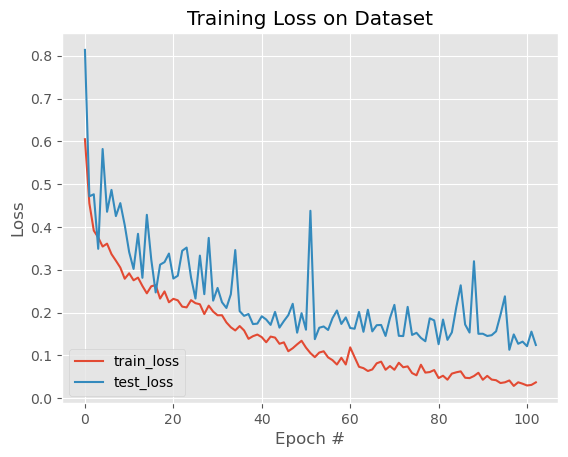

In [8]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")